In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from tqdm import tqdm

In [ ]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Enhanced transformations for CIFAR-10 data
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(10),  # Randomly rotate images by up to 10 degrees
    transforms.RandomCrop(32, padding=4),  # Randomly crop to 32x32 with padding for better localization
    transforms.Resize(224),  # Resize to match ImageNet models input size
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly change color properties
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

transform_test = transforms.Compose([
    transforms.Resize(224),  # Resize to match ImageNet models input size
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

In [ ]:
# Load the CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:03<00:00, 55448890.86it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


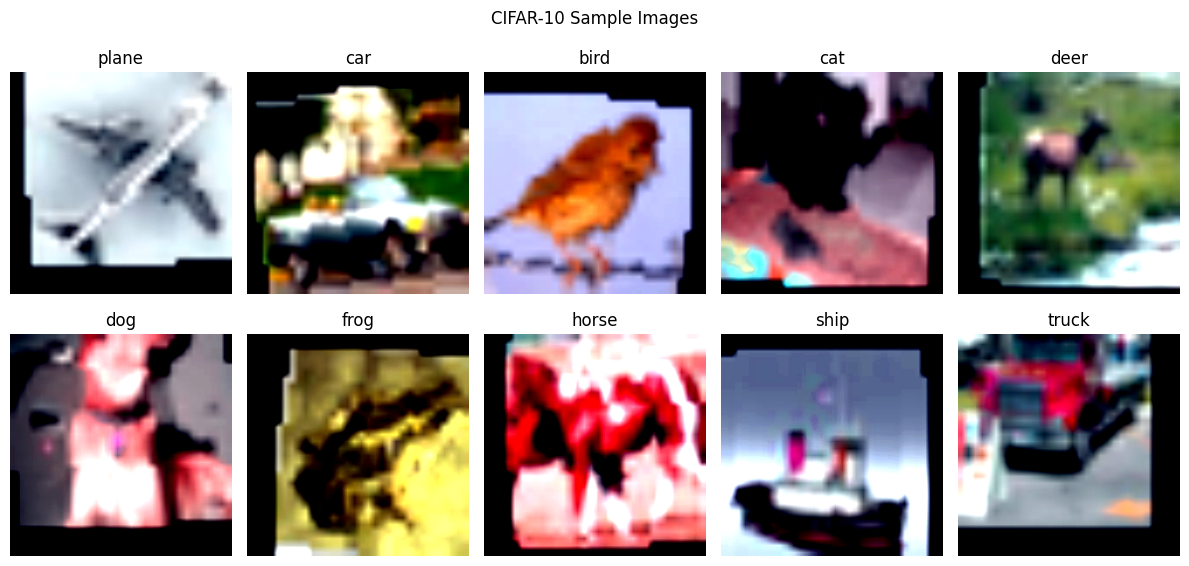

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define a function to display images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # Hide axes
    plt.show()

# Get a batch of training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Define the CIFAR-10 classes
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Create a figure to display images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))  # 2 rows and 5 columns
fig.suptitle('CIFAR-10 Sample Images')

# Display one image from each class
for i in range(10):
    ax = axes[i // 5, i % 5]  # Get the appropriate subplot
    ax.imshow(np.transpose(images[labels == i][1], (1, 2, 0)) / 2 + 0.5)  # Show the first image of the class
    ax.set_title(classes[i])  # Set the title to the class name
    ax.axis('off')  # Hide axes

plt.tight_layout()
plt.show()

In [ ]:
# Function to calculate accuracy and validation loss
def calculate_accuracy_and_loss(loader, model, criterion):
    correct = 0
    total = 0
    val_loss = 0.0
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    accuracy = 100. * correct / total
    avg_val_loss = val_loss / len(loader)
    return accuracy, avg_val_loss

In [ ]:
# Early stopping class
class EarlyStopping:
    def __init__(self, patience=3, delta=0):
        """
        Args:
            patience (int): How many epochs to wait after last time validation accuracy improved.
            delta (float): Minimum change in the monitored metric to qualify as an improvement.
        """
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_acc):
        score = val_acc

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0  # Reset counter if validation accuracy improves

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # Input: 3 channels (RGB), Output: 16 channels
        # Second convolutional layer
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # Input: 16 channels, Output: 32 channels
        # Third convolutional layer
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Input: 32 channels, Output: 64 channels
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling layer with 2x2 kernel
        # Fully connected layer
        self.fc1 = nn.Linear(64 * 28 * 28, 64)  # Input: 64 channels * 28x28 (output size after pooling), Output: 64
        self.fc2 = nn.Linear(64, 10)  # Fully connected layer, output 10 (for CIFAR-10)

    def forward(self, x):
        # Forward pass through the layers
        x = self.pool(torch.relu(self.conv1(x)))  # Conv1 + ReLU + Pooling
        x = self.pool(torch.relu(self.conv2(x)))  # Conv2 + ReLU + Pooling
        x = self.pool(torch.relu(self.conv3(x)))  # Conv3 + ReLU + Pooling
        x = x.view(-1, 64 * 28 * 28)  # Flatten the tensor (after 3 conv + pool)
        x = torch.relu(self.fc1(x))  # Fully connected layer + ReLU
        x = self.fc2(x)  # Output layer
        return x


In [ ]:
# Define function to train the model
def train_model_logging(model, criterion, optimizer, num_epochs=10, patience=3):
    model.to(device)
    early_stopping = EarlyStopping(patience=patience)
    validation_accuracies = []
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        # Use tqdm to track progress
        loop = tqdm(trainloader, leave=False)
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Track loss and accuracy
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Update tqdm progress bar
            loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
            loop.set_postfix(loss=running_loss/len(loop), acc=100.*correct/total)

        # Calculate training accuracy
        train_acc = 100. * correct / total

        # Calculate validation accuracy and loss
        valid_acc, valid_loss = calculate_accuracy_and_loss(testloader, model, criterion)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(trainloader)}, "
              f"Train Accuracy: {train_acc}%, Validation Accuracy: {valid_acc}%, Validation Loss: {valid_loss}")

        # Check early stopping
        early_stopping(valid_acc)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

        validation_accuracies.append(valid_acc)

    print('Training Process done!')

    return validation_accuracies


In [ ]:
# Placeholder to store validation accuracy for each model
validation_accuracies_dict = {}

# Set criterion and optimizer
criterion = nn.CrossEntropyLoss()

In [ ]:
from torchsummary import summary

input_size = (3, 224, 224)

print(f"Model: Baseline")
summary(SimpleCNN().to(device), input_size=input_size)

Model: Baseline
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
         MaxPool2d-2         [-1, 16, 112, 112]               0
            Conv2d-3         [-1, 32, 112, 112]           4,640
         MaxPool2d-4           [-1, 32, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          18,496
         MaxPool2d-6           [-1, 64, 28, 28]               0
            Linear-7                   [-1, 64]       3,211,328
            Linear-8                   [-1, 10]             650
Total params: 3,235,562
Trainable params: 3,235,562
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 13.40
Params size (MB): 12.34
Estimated Total Size (MB): 26.32
----------------------------------------------------------------


In [ ]:
# Train Base Model
baseline = SimpleCNN()

print(f"Baseline Model Training in progress...")
optimizer = optim.SGD(baseline.parameters(), lr=0.001, momentum=0.9)
baseline_val_acc = train_model_logging(baseline, criterion, optimizer)

Baseline Model Training in progress...


Epoch 1/10, Loss: 2.0233888336459693, Train Accuracy: 26.712%, Validation Accuracy: 33.19%, Validation Loss: 1.8384652919830031


Epoch 2/10, Loss: 1.8027208703558157, Train Accuracy: 35.396%, Validation Accuracy: 37.83%, Validation Loss: 1.755777381787634


Epoch 3/10, Loss: 1.7202261178694722, Train Accuracy: 38.342%, Validation Accuracy: 40.79%, Validation Loss: 1.671464808427604


Epoch 4/10, Loss: 1.6418042878055816, Train Accuracy: 41.352%, Validation Accuracy: 42.77%, Validation Loss: 1.587873948607475


Epoch 5/10, Loss: 1.5565562172009206, Train Accuracy: 43.998%, Validation Accuracy: 45.36%, Validation Loss: 1.5245952158217217


Epoch 6/10, Loss: 1.4923535126554386, Train Accuracy: 46.368%, Validation Accuracy: 46.25%, Validation Loss: 1.4782100308472943


Epoch 7/10, Loss: 1.446440246251538, Train Accuracy: 47.878%, Validation Accuracy: 49.17%, Validation Loss: 1.4077898742287023


Epoch 8/10, Loss: 1.408766998506873, Train Accuracy: 49.504%, Validation Accuracy: 50.92%, Validation Loss: 1.378856967209251


Epoch 9/10, Loss: 1.3770854389271163, Train Accuracy: 50.508%, Validation Accuracy: 51.83%, Validation Loss: 1.3465464327745378


Epoch 10/10, Loss: 1.3514283321550131, Train Accuracy: 51.65%, Validation Accuracy: 52.41%, Validation Loss: 1.3421348143535055
Training Process done!


In [ ]:
# Model list: VGG16, VGG19, ResNet18, ResNet34, ResNet50
models_sample = {
    'ResNet18': models.resnet18(pretrained=True),
    'ResNet34': models.resnet34(pretrained=True),
    'ResNet50': models.resnet50(pretrained=True),
    'VGG16': models.vgg16(pretrained=True),
    'VGG19': models.vgg19(pretrained=True),
    'EfficientNetV2': models.efficientnet_v2_m(pretrained=True)
}

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 123MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed i

In [ ]:
# Print the summary for each model
input_size = (3, 224, 224)
for model_name, model in models_sample.items():
    print(f"Model: {model_name}")
    summary(model.to(device), input_size=input_size)
    print("="*60)

Model: ResNet18
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14   

In [ ]:
# Modify the final layer to match CIFAR-10's 10 classes
for model_name, model in models_sample.items():
    if "vgg" in model_name.lower():
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, 10)  # For VGG models
    if "efficient" in model_name.lower():
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 10)
    else:
        model.fc = nn.Linear(model.fc.in_features, 10)  # For ResNet models


# Train and evaluate all models
for model_name, model in models_sample.items():
    print(f"\nTraining {model_name} in progress...")
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    validation_accuracies_dict[model_name] = train_model_logging(model, criterion, optimizer)


Training ResNet18 in progress...
Epoch 1/10, Loss: 0.47668695155426366, Train Accuracy: 84.976%, Validation Accuracy: 92.55%, Validation Loss: 0.2194991246530205
Epoch 2/10, Loss: 0.17385227402286305, Train Accuracy: 94.236%, Validation Accuracy: 94.07%, Validation Loss: 0.17671046790423667
Epoch 3/10, Loss: 0.101971233235029, Train Accuracy: 96.838%, Validation Accuracy: 94.24%, Validation Loss: 0.17245463917779316
Epoch 4/10, Loss: 0.06313689293094513, Train Accuracy: 98.174%, Validation Accuracy: 94.55%, Validation Loss: 0.15985232828908666
Epoch 5/10, Loss: 0.038544629218742785, Train Accuracy: 99.046%, Validation Accuracy: 94.93%, Validation Loss: 0.16250191691812058
Epoch 6/10, Loss: 0.02379645123485895, Train Accuracy: 99.578%, Validation Accuracy: 94.85%, Validation Loss: 0.16796384704340794
EarlyStopping counter: 1 out of 3
Epoch 7/10, Loss: 0.01590880174460747, Train Accuracy: 99.76%, Validation Accuracy: 94.82%, Validation Loss: 0.16871135167563986
EarlyStopping counter: 2 

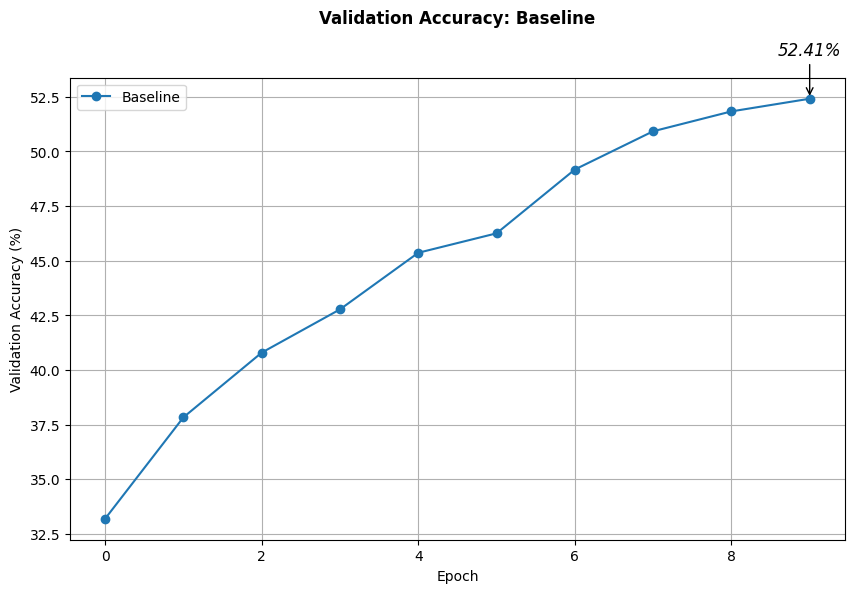

In [ ]:
# Find the best validation accuracy for the baseline model
import matplotlib.pyplot as plt
baseline_best_epoch = baseline_val_acc.index(max(baseline_val_acc))
baseline_best_val_acc = max(baseline_val_acc)

plt.figure(figsize=(10, 6))

# Plot baseline validation accuracy
plt.plot(baseline_val_acc, label='Baseline', linestyle='-', marker='o')
# Annotate the best accuracy for the baseline model
plt.annotate(
    f'{baseline_best_val_acc:.2f}%',
    xy=(baseline_best_epoch, baseline_best_val_acc),
    xytext=(baseline_best_epoch, baseline_best_val_acc + 2),  # Increase offset for visibility
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=12,
    ha='center',
    fontstyle='italic'
)

# Adjust the title position
plt.title(f'Validation Accuracy: Baseline', y=1.1, fontweight='bold')  # Move title up
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()


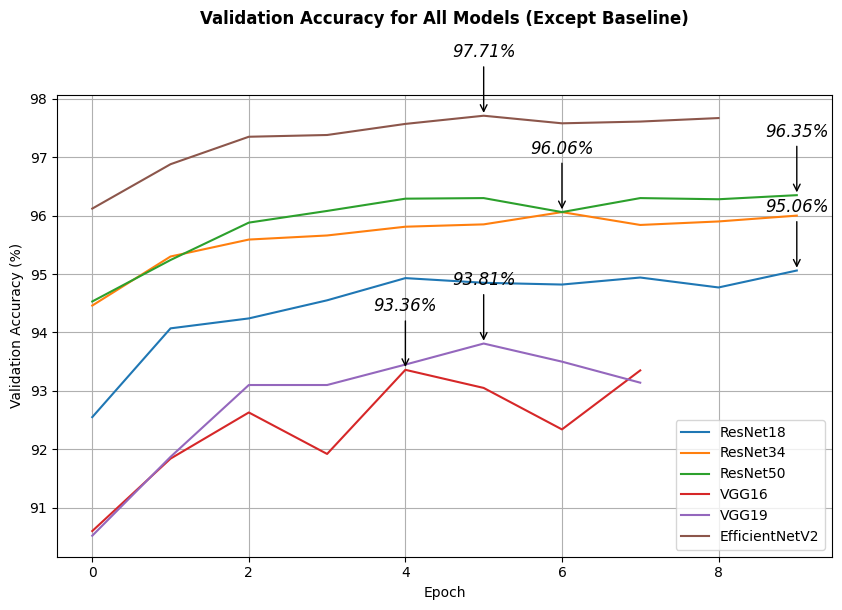

In [ ]:


# First Chart: All models except baseline
plt.figure(figsize=(10, 6))

# Loop through each model's validation accuracies
for model, val_acc in validation_accuracies_dict.items():
    plt.plot(val_acc, label=model)

    # Find the best validation accuracy and the corresponding epoch
    best_epoch = val_acc.index(max(val_acc))
    best_val_acc = max(val_acc)

    # Annotate the best accuracy on the chart
    plt.annotate(
        f'{best_val_acc:.2f}%',
        xy=(best_epoch, best_val_acc),
        xytext=(best_epoch, best_val_acc + 1),  # Offset the text a bit for visibility
        arrowprops=dict(facecolor='black', arrowstyle='->'),
        fontsize=12,
        ha='center',
        fontstyle='italic'
    )

plt.title('Validation Accuracy for All Models (Except Baseline)\n\n\n', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()


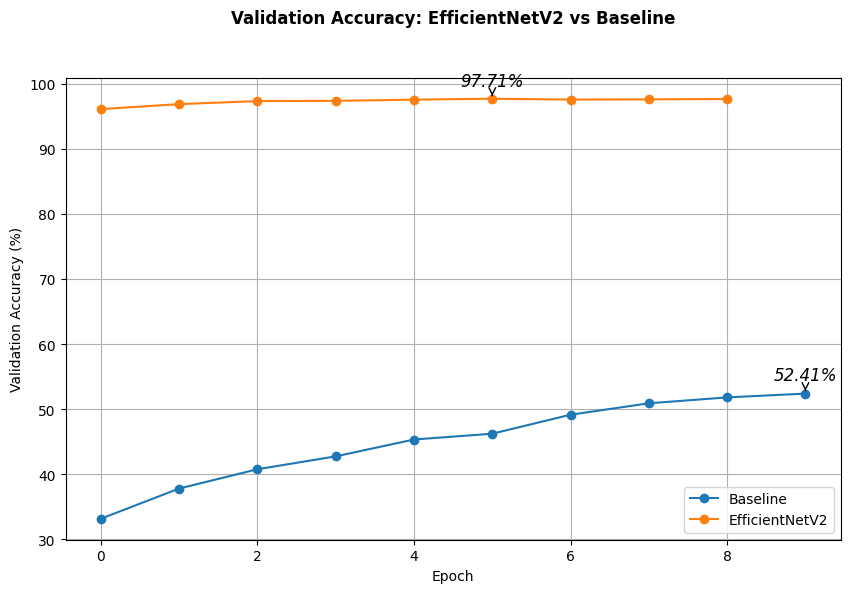

In [ ]:
# Second Chart: Comparison of the best model (EfficientNetV2) with the baseline
best_model = 'EfficientNetV2'
best_model_val_acc = validation_accuracies_dict[best_model]

plt.figure(figsize=(10, 6))

# Plot baseline validation accuracy
plt.plot(baseline_val_acc, label='Baseline', linestyle='-', marker='o')

# Plot best model validation accuracy
plt.plot(best_model_val_acc, label=best_model, linestyle='-', marker='o')

# Find the best validation accuracy for the best model
best_epoch = best_model_val_acc.index(max(best_model_val_acc))
best_val_acc = max(best_model_val_acc)

# Annotate the best accuracy for the best model
plt.annotate(
    f'{best_val_acc:.2f}%',
    xy=(best_epoch, best_val_acc),
    xytext=(best_epoch, best_val_acc + 2),  # Increase offset for visibility
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=12,
    ha='center',
    fontstyle='italic'
)


# Annotate the best accuracy for the baseline model
plt.annotate(
    f'{baseline_best_val_acc:.2f}%',
    xy=(baseline_best_epoch, baseline_best_val_acc),
    xytext=(baseline_best_epoch, baseline_best_val_acc + 2),  # Increase offset for visibility
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=12,
    ha='center',
    fontstyle='italic'
)

# Adjust the title position
plt.title(f'Validation Accuracy: {best_model} vs Baseline', y=1.1, fontweight='bold')  # Move title up
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()
